In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [183]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

from imblearn.over_sampling import SMOTE

import joblib

In [184]:
# import dataset
df = pd.read_csv("cicddos2019.csv")

In [185]:
# display first 10 values
df.head()

,Unnamed: 0,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Class
0,271174,17,449,98,0,42832.0,0.0,440.0,296.0,437.06122,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DrDoS_NTP,Attack
1,24038,6,16696066,8,6,48.0,36.0,6.0,6.0,6.00000,...,499965.0,706911.6,999827.0,103.0,7848067.5,1628737.8,8999759.0,6696376.0,Syn,Attack
2,44954,17,3008437,4,0,2064.0,0.0,516.0,516.0,516.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TFTP,Attack
3,53199,17,3112318,4,0,2064.0,0.0,516.0,516.0,516.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TFTP,Attack
4,8940,17,215106,6,0,2088.0,0.0,393.0,321.0,348.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UDP,Attack


In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 80 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                50000 non-null  int64  
 1   Protocol                  50000 non-null  int64  
 2   Flow Duration             50000 non-null  int64  
 3   Total Fwd Packets         50000 non-null  int64  
 4   Total Backward Packets    50000 non-null  int64  
 5   Fwd Packets Length Total  50000 non-null  float64
 6   Bwd Packets Length Total  50000 non-null  float64
 7   Fwd Packet Length Max     50000 non-null  float64
 8   Fwd Packet Length Min     50000 non-null  float64
 9   Fwd Packet Length Mean    50000 non-null  float64
 10  Fwd Packet Length Std     50000 non-null  float64
 11  Bwd Packet Length Max     50000 non-null  float64
 12  Bwd Packet Length Min     50000 non-null  float64
 13  Bwd Packet Length Mean    50000 non-null  float64
 14  Bwd Pa

In [187]:
# drop label column as it isn't important for this project
df.drop(['Label', 'Unnamed: 0'], axis=1, inplace=True)

In [188]:
df.columns

Index(['Protocol', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Fwd Packets Length Total',
       'Bwd Packets Length Total', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Fla

In [189]:
# label attack as 1 and benign as 0
df['Class'] = df['Class'].apply(lambda x: 1 if x=='Attack' else 0)

In [190]:
df['Class'].value_counts()

,count
Class,
1,38607
0,11393


In [191]:
test_size = 3000

# separate classes
attack_df = df[df['Class'] == 1]
benign_df = df[df['Class'] == 0]

# sample equal number of rows from both
attack_test = attack_df.sample(n=test_size, random_state=42)
benign_test = benign_df.sample(n=test_size, random_state=42)

# combine
test_df = pd.concat([attack_test, benign_test])
train_df = df.drop(test_df.index)


In [192]:
# checking the distribution
test_df['Class'].value_counts()

,count
Class,
1,3000
0,3000


In [193]:
train_df['Class'].value_counts()

,count
Class,
1,35607
0,8393


In [194]:
# separate features and label
X_train = train_df.drop('Class', axis=1)
y_train = train_df['Class']

# standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [195]:
# # keep enough components to explain 95% variance
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)

print(f"Original shape: {X_train_scaled.shape}")
print(f"Reduced shape: {X_train_pca.shape}")

Original shape: (44000, 77)
Reduced shape: (44000, 22)


In [196]:
# # combine reduced features into a dataframe for easy manipulation
df_train_pca = pd.DataFrame(X_train_pca)
df_train_pca['Class'] = y_train.values
df_train_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,Class
0,-2.227236,0.809736,-0.219436,3.203830,0.024040,0.683881,0.157696,0.039861,-0.357240,-0.026757,...,0.037024,0.125863,0.009152,0.062137,-0.177210,-0.129162,-0.056691,0.102383,0.206936,1
1,4.405746,-1.646128,0.508345,0.305536,1.818056,-1.066640,-1.009061,-0.571557,-0.156857,0.225008,...,1.646159,-0.633106,0.005530,-0.409171,0.209364,-0.027442,0.322051,-0.956617,-0.013039,1
2,-1.468071,0.198517,-1.078484,-0.976924,-0.378763,-0.920336,-0.120468,0.107950,0.481045,0.541013,...,-0.023523,-0.083529,0.007211,-0.084396,0.075929,0.206610,0.012981,-0.163731,-0.067050,1
3,-1.444542,0.196194,-1.095732,-0.977415,-0.382440,-0.927134,-0.111294,0.116522,0.480728,0.543994,...,-0.023556,-0.086390,0.008411,-0.088642,0.076000,0.211705,0.011877,-0.158770,-0.065310,1
4,11.651772,-1.430978,-4.393466,0.969940,-0.152697,1.964668,-0.079359,-4.355263,-0.828411,-2.274726,...,-2.512597,-0.600275,0.771227,-0.507090,-0.315605,2.703383,-2.071374,1.207711,-0.306081,1


In [197]:
# generates the correlation matrix
pca_corr_matrix= df_train_pca.corr()

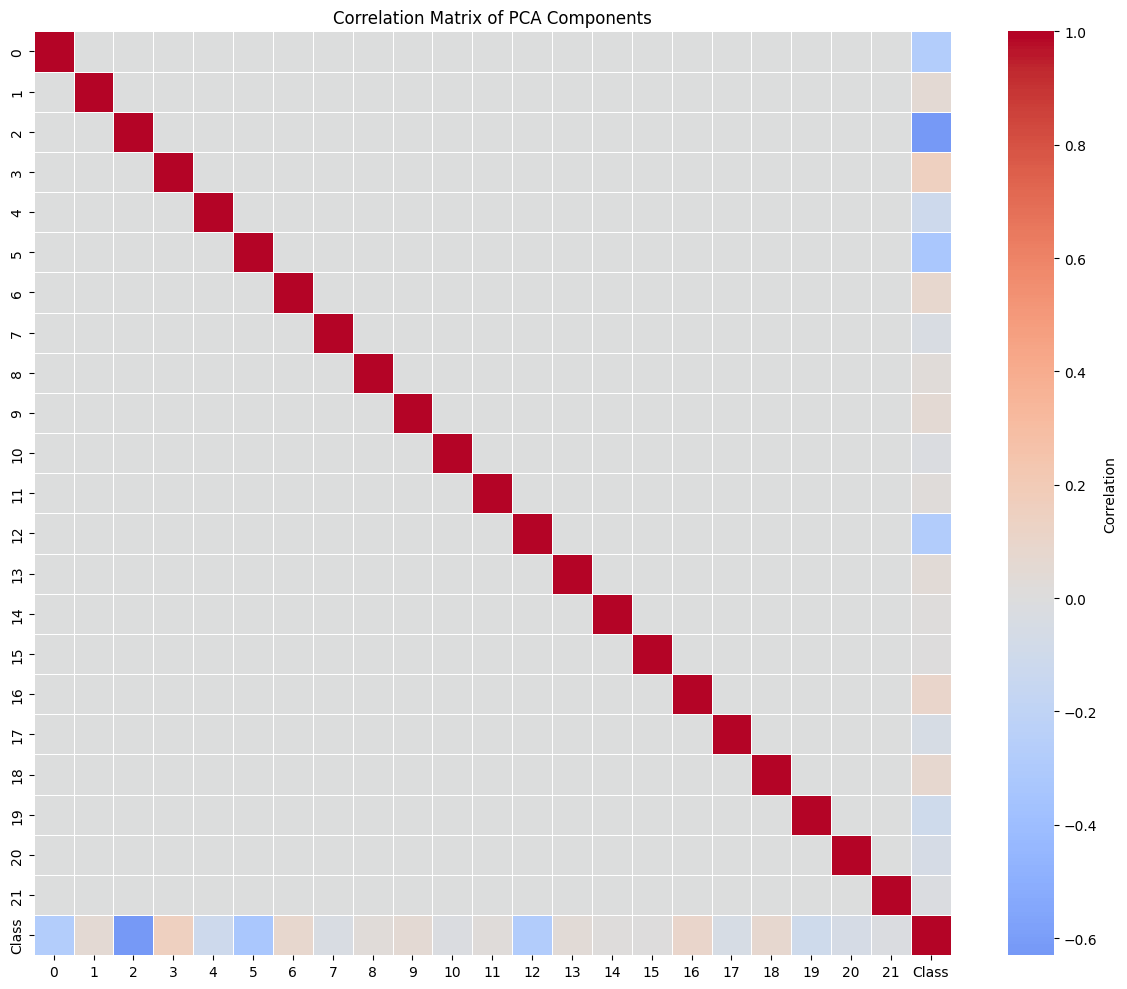

In [198]:
#visualize the corr matrix

plt.figure(figsize=(12, 10))
sns.heatmap(pca_corr_matrix, annot=False, cmap='coolwarm', center=0,
            linewidths=0.5, cbar_kws={'label': 'Correlation'})
plt.title("Correlation Matrix of PCA Components")
plt.tight_layout()

In [199]:
# splitting into train test sets
X_train, y_train = df_train_pca.drop('Class', axis=1), df_train_pca['Class']
X_test, y_test = test_df.drop('Class', axis=1), test_df['Class']

In [200]:
X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)
X_test = X_test_pca

In [201]:
# perfrom oversampling using SMOTE
smote_resampler = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)

X_train_res, y_train_res = smote_resampler.fit_resample(X_train, y_train)

In [202]:
# verifying the oversampling
y_train_res.value_counts()

,count
Class,
1,35607
0,35607


In [203]:
# train random forest classifier
model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X_train_res, y_train_res)

y_pred = model.predict(X_test)

In [204]:
# evaluate the model
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3000
           1       1.00      1.00      1.00      3000

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000

Confusion Matrix:

[[2996    4]
 [   7 2993]]


In [205]:
#save the model, scaler and pca
joblib.dump(model, 'ddos_random_forest_model_1.pkl')
joblib.dump(scaler, 'ddos_scaler_1.pkl')
joblib.dump(pca, 'ddos_pca_1.pkl')

['ddos_pca_1.pkl']